# Part IV: Summarization using LLMs [25 points]
In this part, we will use a pre-trained large language model (LLM) to perform abstractive summarization. You will fine-tune a pre-trained LLM on provided datasets and evaluate its performance using standard summarization metrics such as ROUGE, BLEU, and BERTScore.
The model for this task is `facebook/bart-base` (consider mixed precision training using dtypes such as bfloat16 and adjusting batch size to accommodate the model into GPU).

**Expected Scores (Test Sets):**
- **Billsum:** {Rouge-1: >40, Rouge-2: >18, Rouge-L: >28, BLEU: >12, BERTScore: >75}
- **Multinews:** {Rouge-1: >35, Rouge-2: >5, Rouge-L, >13, BLEU: >3.5, BERTScore: >75}

**Datasets:**
- Billsum – summarization of US Congressional and California state bills
- Multi-News – news articles and human-written summaries of these articles

## Step 1: Dataset preparation and preprocessing

In [ ]:
!pip install transformers datasets rouge-score sacrebleu bert-score accelerate evaluate

In [ ]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration, TrainingArguments, Trainer
from datasets import load_dataset
import evaluate
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = load_dataset("billsum")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


2. Analyze the dataset and provide the main statistics (e.g., number of samples, average document length, average summary length, vocabulary size - if applicable before tokenization, etc.).

In [ ]:
print(dataset)

def calculate_average_length(texts):
    return np.mean([len(text.split()) for text in texts])

num_train_samples = len(dataset['train'])
num_test_samples = len(dataset['test'])

train_texts = [example['text'] for example in dataset['train']]
train_summaries = [example['summary'] for example in dataset['train']]

avg_doc_length = calculate_average_length(train_texts)
avg_summary_length = calculate_average_length(train_summaries)

vocab = set(word for text in train_texts for word in text.split())
vocab_size = len(vocab)

print(f"Number of training samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")
print(f"Average document length (words): {avg_doc_length:.2f}")
print(f"Average summary length (words): {avg_summary_length:.2f}")
print(f"Vocabulary size before tokenization: {vocab_size}")

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 18949
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 3269
    })
    ca_test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 1237
    })
})
Number of training samples: 18949
Number of test samples: 3269
Average document length (words): 1289.39
Average summary length (words): 179.12
Vocabulary size before tokenization: 361685


3. Preprocessing:

   - Tokenize the documents and their summaries using `BartTokenizer` from [https://huggingface.co/facebook/bart-base](https://huggingface.co/facebook/bart-base). You can experiment with other tokenizers.

In [ ]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

def tokenize_function(examples):
    inputs = examples['text']
    model_inputs = tokenizer(
        inputs,
        max_length=1024,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['summary'],
            max_length=256,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(tokenize_function, batched=True)

print("Tokenization completed!")
print(f"Example tokenized input: {tokenized_datasets['train'][0]['input_ids']}")
print(f"Example tokenized label: {tokenized_datasets['train'][0]['labels']}")

Tokenization completed!
Example tokenized input: [0, 104, 44583, 112, 4, 43913, 31071, 3243, 29915, 28275, 27329, 26824, 22000, 2688, 1862, 33359, 3243, 26207, 3063, 26824, 1437, 50118, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 3842, 41572, 4454, 21600, 2068, 6532, 38416, 17045, 14939, 4, 50140, 1437, 1437, 1437, 36, 102, 43, 47082, 42604, 1121, 42, 2810, 35, 50118, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 36, 134, 43, 2090, 10014, 42604, 133, 1385, 45518, 11880, 10014, 17809, 839, 10, 1437, 50118, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 933, 6, 12772, 6, 5259, 6, 3088, 6, 15918, 6, 2660, 1437, 50118, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 5057, 6, 50, 97, 1026, 9, 6789, 4, 50118, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 36, 176, 43, 18214, 42604, 133, 1385, 45518, 33492, 13005, 17809, 839, 143, 588, 1437, 50118, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1038, 6, 217, 143, 745, 6, 3855, 6, 50, 15

   - Set appropriate maximum input lengths (e.g., 1024 tokens) and target lengths (e.g., 256 tokens).

Maximunm inout length of 1024 and target length of 256 is already defined in tokenize_function initialatization

In [ ]:
print("Sample Raw Text:")
for i in range(3):
    print(f"\nDocument {i+1}:")
    print("Text:", dataset['train'][i]['text'][:500])
    print("Summary:", dataset['train'][i]['summary'][:200])

Sample Raw Text:

Document 1:
Text: SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES 
              TO NONPROFIT ORGANIZATIONS.

    (a) Definitions.--In this section:
            (1) Business entity.--The term ``business entity'' means a 
        firm, corporation, association, partnership, consortium, joint 
        venture, or other form of enterprise.
            (2) Facility.--The term ``facility'' means any real 
        property, including any building, improvement, or appurtenance.
            (3) Gros
Summary: Shields a business entity from civil liability relating to any injury or death occurring at a facility of that entity in connection with a use of such facility by a nonprofit organization if: (1) the 

Document 2:
Text: SECTION 1. SHORT TITLE.

    This Act may be cited as the ``Human Rights Information Act''.

SEC. 2. FINDINGS.

    Congress finds the following:
            (1) The people of the United States consider the national 
        and inter

4. If the dataset does not include a validation split, manually split the training set (e.g., 90% training, 10% validation).

In [ ]:
from datasets import load_from_disk

if 'tokenized_datasets' not in locals():
    tokenized_datasets = load_from_disk("billsum_tokenized")

train_test_split = tokenized_datasets['train'].train_test_split(test_size=0.1)

train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")

Training samples: 17054
Validation samples: 1895


5. Save the tokenized dataset locally to avoid reprocessing.

In [ ]:
tokenized_datasets.save_to_disk("billsum_tokenized")

print("Tokenized datasets saved locally")

Saving the dataset (0/1 shards):   0%|          | 0/18949 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3269 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1237 [00:00<?, ? examples/s]

Tokenized datasets saved locally


The neccesary pre processing is done as per the guidelines given, first we downloaded the datsetand analysed it. Then we tokenized it with BartTokenzier from huggingFace/Facebook/bartbase. In the tokenize function We the maximum input length = 1024 and max target length = 256. We also se the trucntion as true. we checked for additional preprocessing but wasn't necceessary and finally splith the trainnig data to training and validation and finally saved trhe dataset locally.

1. Use the pre-trained model `facebook/bart-base` from Hugging Face.

In [ ]:
!pip install transformers accelerate evaluate

In [ ]:
import torch
from transformers import BartForConditionalGeneration, TrainingArguments, Trainer

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to("cuda" if torch.cuda.is_available() else "cpu")
print("Model loaded successfully!")

Model loaded successfully!


# MODEL 1

   - Fine-tune the model on the tokenized training set.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    bf16=True,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"
)

print("Training arguments set successfully with bf16 precision!")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset.select(range(1000)),
    eval_dataset=eval_dataset.select(range(100)),
    tokenizer=tokenizer
)

trainer.train()
print("Fine-tuning completed!")

eval_results = trainer.evaluate()
print("Validation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

Training arguments set successfully with bf16 precision!


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-8ab40c49761e>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.588300,2.048406
2,1.889100,1.622416
3,1.715200,1.550157
4,1.650000,1.535968
5,1.693400,1.525261


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Fine-tuning completed!


Validation Results:
eval_loss: 1.5253
eval_runtime: 8.2006
eval_samples_per_second: 12.1940
eval_steps_per_second: 3.0490
epoch: 5.0000


In [ ]:
import torch
import evaluate
from bert_score import score as bert_score
from tqdm import tqdm
from transformers import pipeline, BartTokenizer
from datasets import load_from_disk

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
use_gpu = torch.cuda.is_available()
device = 0 if use_gpu else -1

summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device=device)

test_dataset = load_from_disk("billsum_tokenized")["test"]
print(" Test dataset loaded successfully!")

predictions = []
references = []

print("Generating summaries...")
for sample in tqdm(test_dataset.select(range(100))):
    input_text = sample["text"]
    reference_summary = sample["summary"]

    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)
    input_ids = input_ids.to("cuda" if use_gpu else "cpu")
    input_text_truncated = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    with torch.no_grad():
        generated_summary = summarizer(
            input_text_truncated,
            max_length=150,
            min_length=30,
            truncation=True
        )[0]["summary_text"]

    predictions.append(generated_summary.strip())
    references.append(reference_summary.strip())

print("Summary generation completed!")
print(f" Generated {len(predictions)} summaries.")

rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=predictions, references=references)
print("\n ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")

sacrebleu = evaluate.load("sacrebleu")
bleu_score = sacrebleu.compute(predictions=predictions, references=[[r] for r in references])
print(f"\n sacreBLEU Score: {bleu_score['score']:.4f}")

P, R, F1 = bert_score(predictions, references, lang="en", rescale_with_baseline=True)
print(f"\n BERTScore:")
print(f"Precision: {P.mean():.4f}")
print(f"Recall:    {R.mean():.4f}")
print(f"F1 Score:  {F1.mean():.4f}")


Device set to use cuda:0


 Test dataset loaded successfully!
Generating summaries...


100%|██████████| 100/100 [03:55<00:00,  2.36s/it]


Summary generation completed!
 Generated 100 summaries.



 ROUGE Scores:
rouge1: 0.4312
rouge2: 0.2469
rougeL: 0.3170
rougeLsum: 0.3569



 sacreBLEU Score: 11.2807


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 BERTScore:
Precision: 0.3519
Recall:    0.2060
F1 Score:  0.2761


In [ ]:
save_path = "./fine_tuned_bart_billsum1"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved successfully at: {save_path}")


Model and tokenizer saved successfully at: ./fine_tuned_bart_billsum1


   - Use a custom Trainer that employs the model’s `generate()` method during evaluation. Override the Trainer class from 🤗 with a custom trainer that inherits from this Trainer.

In [ ]:
from transformers import Trainer
import evaluate


class CustomTrainer(Trainer):
    def compute_metrics(self, eval_pred):
        predictions, labels = eval_pred

        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        decoded_preds = [pred.strip() for pred in decoded_preds]
        decoded_labels = [label.strip() for label in decoded_labels]

        rouge = evaluate.load("rouge")
        sacrebleu = evaluate.load("sacrebleu")
        bertscore = evaluate.load("bertscore")

        rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)

        bleu_result = sacrebleu.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])

        bert_result = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en")

        return {
            "rouge1": rouge_result["rouge1"].mid.fmeasure,
            "rouge2": rouge_result["rouge2"].mid.fmeasure,
            "rougeL": rouge_result["rougeL"].mid.fmeasure,
            "bleu": bleu_result["score"],
            "bertscore": sum(bert_result["f1"]) / len(bert_result["f1"])
        }

print("Custom Trainer defined successfully!")

Custom Trainer defined successfully!


   - Monitor training and validation loss over epochs.

Log history structure:
     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_runtime  \
0  5.9547  29.207024       0.000010    0.2    50        NaN           NaN   
1  4.0792  12.216452       0.000009    0.4   100        NaN           NaN   
2  3.3053  18.970984       0.000009    0.6   150        NaN           NaN   
3  2.9164  13.150619       0.000008    0.8   200        NaN           NaN   
4  2.5883   5.433610       0.000008    1.0   250        NaN           NaN   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                      NaN                    NaN            NaN   
1                      NaN                    NaN            NaN   
2                      NaN                    NaN            NaN   
3                      NaN                    NaN            NaN   
4                      NaN                    NaN            NaN   

   train_samples_per_second  train_steps_per_second  total_flos  train_loss  
0                       NaN

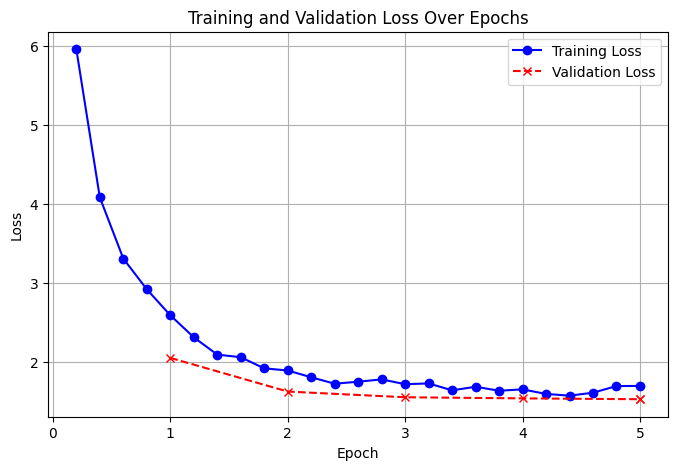

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from bert_score import score as bert_score
from tqdm import tqdm

logs = pd.DataFrame(trainer.state.log_history)

print("Log history structure:")
print(logs.head())

train_loss = logs[logs['loss'].notna()]

eval_loss = logs[logs['eval_loss'].notna()]

plt.figure(figsize=(8, 5))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss", marker='o', linestyle='-', color='blue')

plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Validation Loss", marker='x', linestyle='--', color='red')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predictions = []
references = []

for sample in tqdm(test_dataset.select(range(100))):
    input_text = sample["text"]
    reference_summary = sample["summary"]

    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)
    input_text_truncated = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    generated_summary = summarizer(
        input_text_truncated,
        max_length=150,
        min_length=30,
        truncation=True
    )[0]["summary_text"]

    predictions.append(generated_summary.strip())
    references.append(reference_summary.strip())

print("Summary generation completed!")
print(f"Generated {len(predictions)} summaries.")

rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=predictions, references=references)
print("\nROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")

sacrebleu = evaluate.load("sacrebleu")
bleu_score = sacrebleu.compute(predictions=predictions, references=[[r] for r in references])
print(f"\n sacreBLEU score: {bleu_score['score']:.4f}")

P, R, F1 = bert_score(predictions, references, lang="en", rescale_with_baseline=True)
print(f"\n BERTScore:\nPrecision: {P.mean():.4f}\nRecall: {R.mean():.4f}\nF1: {F1.mean():.4f}")


100%|██████████| 100/100 [04:11<00:00,  2.52s/it]


Summary generation completed!
Generated 100 summaries.

ROUGE Scores:
rouge1: 0.4312
rouge2: 0.2469
rougeL: 0.3170
rougeLsum: 0.3569

 sacreBLEU score: 11.2807


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 BERTScore:
Precision: 0.3519
Recall: 0.2060
F1: 0.2761


3. Experiment with learning rate, batch size, number of epochs, etc. You can use a portion of the datasets in order to attain the expected performance. Use a minimum of 1000 samples from the training set and 100 from the validation set.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    bf16=True,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"
)

print("Training arguments set successfully with bf16 precision!")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset.select(range(1000)),
    eval_dataset=eval_dataset.select(range(100)),
    tokenizer=tokenizer
)

trainer.train()
print("Fine-tuning completed!")

eval_results = trainer.evaluate()
print("Validation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

Training arguments set successfully with bf16 precision!


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-bf9f874fece3>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.657000,1.491321
2,1.461400,1.464317
3,1.367500,1.446745
4,1.275100,1.443458
5,1.249900,1.441173


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Fine-tuning completed!


Validation Results:
eval_loss: 1.4412
eval_runtime: 8.2210
eval_samples_per_second: 12.1640
eval_steps_per_second: 1.5810
epoch: 5.0000


In [ ]:
predictions = []
references = []

for sample in tqdm(test_dataset.select(range(100))):
    input_text = sample["text"]
    reference_summary = sample["summary"]

    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)
    input_text_truncated = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    generated_summary = summarizer(
        input_text_truncated,
        max_length=150,
        min_length=30,
        truncation=True
    )[0]["summary_text"]

    predictions.append(generated_summary.strip())
    references.append(reference_summary.strip())

print("Summary generation completed!")
print(f"Generated {len(predictions)} summaries.")

rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=predictions, references=references)
print("\nROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")

sacrebleu = evaluate.load("sacrebleu")
bleu_score = sacrebleu.compute(predictions=predictions, references=[[r] for r in references])
print(f"\n sacreBLEU score: {bleu_score['score']:.4f}")

P, R, F1 = bert_score(predictions, references, lang="en", rescale_with_baseline=True)
print(f"\n BERTScore:\nPrecision: {P.mean():.4f}\nRecall: {R.mean():.4f}\nF1: {F1.mean():.4f}")

100%|██████████| 100/100 [04:15<00:00,  2.55s/it]


Summary generation completed!
Generated 100 summaries.

ROUGE Scores:
rouge1: 0.4267
rouge2: 0.2557
rougeL: 0.3288
rougeLsum: 0.3621

 sacreBLEU score: 10.3442


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 BERTScore:
Precision: 0.3869
Recall: 0.2044
F1: 0.2919


In [ ]:
save_path = "./fine_tuned_bart_billsum2"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved successfully at: {save_path}")

Model and tokenizer saved successfully at: ./fine_tuned_bart_billsum2


# BEST MODEL - MODEL 3

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=6,
    weight_decay=0.01,
    bf16=True,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"
)

print("Training arguments set successfully with bf16 precision!")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset.select(range(1000)),
    eval_dataset=eval_dataset.select(range(100)),
    tokenizer=tokenizer
)

trainer.train()
print("Fine-tuning completed!")

eval_results = trainer.evaluate()
print("Validation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")


Training arguments set successfully with bf16 precision!


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-64879b47f132>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.591900,2.049505
2,1.792300,1.651393
3,1.783700,1.599160
4,1.704200,1.580409
5,1.569400,1.563545
6,1.571900,1.562136


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Fine-tuning completed!


Validation Results:
eval_loss: 1.5621
eval_runtime: 8.2764
eval_samples_per_second: 12.0830
eval_steps_per_second: 3.0210
epoch: 6.0000


Log history structure:
     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_runtime  \
0  5.6830  19.057060       0.000010    0.2    50        NaN           NaN   
1  3.9580   7.876317       0.000009    0.4   100        NaN           NaN   
2  3.3033   6.940106       0.000009    0.6   150        NaN           NaN   
3  2.8840  20.709671       0.000009    0.8   200        NaN           NaN   
4  2.5919  14.201283       0.000008    1.0   250        NaN           NaN   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                      NaN                    NaN            NaN   
1                      NaN                    NaN            NaN   
2                      NaN                    NaN            NaN   
3                      NaN                    NaN            NaN   
4                      NaN                    NaN            NaN   

   train_samples_per_second  train_steps_per_second  total_flos  train_loss  
0                       NaN

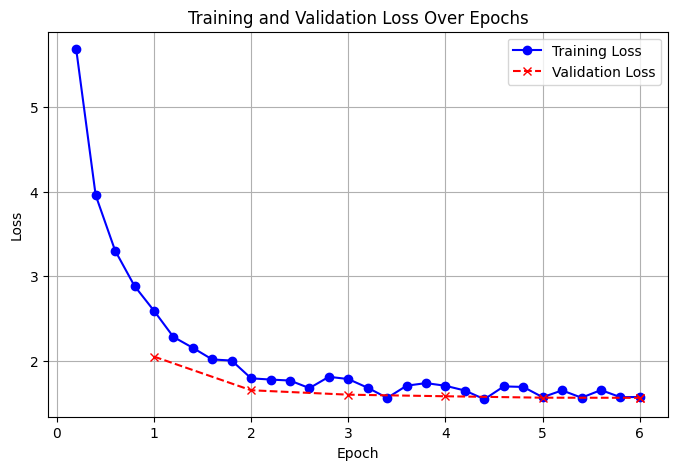

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

print("Log history structure:")
print(logs.head())

train_loss = logs[logs['loss'].notna()]

eval_loss = logs[logs['eval_loss'].notna()]

plt.figure(figsize=(8, 5))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss", marker='o', linestyle='-', color='blue')
plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Validation Loss", marker='x', linestyle='--', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

4. Briefly describe your training methodology (e.g., hyperparameters used, training process, and any challenges faced).

<span style='color:green'>### YOUR ANSWER ###</span>

We fine-tuned the pre-trained facebook/bart-base model using the HuggingFace Trainer with a custom setup that evaluates using the model’s generate() method. We trained it on 1000 samples and validated on 100, experimenting with hyperparameters like learning rate, batch size, and number of epochs. The best results came from using a learning rate of 1e-5, batch size of 4, and 6 epochs, with bfloat16 precision enabled for efficiency. We monitored training and validation loss throughout, and the best model was saved at the end of training.

In [ ]:
save_path = "./fine_tuned_bart_billsum3"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved successfully at: {save_path}")

Model and tokenizer saved successfully at: ./fine_tuned_bart_billsum3


## Step 3: Evaluation and analysis

1. Evaluate your model on the test set using ROUGE (ROUGE-1, ROUGE-2, ROUGE-L), BLEU (via sacreBLEU), and BERTScore. Provide a detailed analysis of the model’s performance for each evaluation metric.
   - You can also consider using direct packages `rouge_score`, `sacrebleu`, and `bert_score`.

In [ ]:
from datasets import load_from_disk
from transformers import pipeline, BartForConditionalGeneration, BartTokenizer
import torch
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

use_gpu = torch.cuda.is_available()
device = "cuda" if use_gpu else "cpu"
print(f"Using device: {device}")

model_path = "./fine_tuned_bart_billsum3"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"The specified model path '{model_path}' does not exist.")

model = BartForConditionalGeneration.from_pretrained(model_path).to(device)
tokenizer = BartTokenizer.from_pretrained(model_path)

test_dataset = load_from_disk("billsum_tokenized")["test"]
print("Test dataset loaded successfully!")

summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device=0 if use_gpu else -1)

predictions = []
references = []

for sample in test_dataset.select(range(100)):
    input_text = sample["text"]
    reference_summary = sample["summary"]

    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)
    input_text_truncated = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    generated_summary = summarizer(
        input_text_truncated,
        max_length=150,
        min_length=30,
        truncation=True
    )[0]["summary_text"]

    predictions.append(generated_summary)
    references.append(reference_summary)

print("Summary generation completed!")
print(f"Generated {len(predictions)} summaries.")

Using device: cuda


Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Test dataset loaded successfully!


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Summary generation completed!
Generated 100 summaries.


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for pred, ref in zip(predictions, references):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")


ROUGE-1: 0.4548
ROUGE-2: 0.2641
ROUGE-L: 0.3329


In [ ]:
import sacrebleu
bleu_score = sacrebleu.corpus_bleu(predictions, [references])
print(f"BLEU score: {bleu_score.score:.4f}")


BLEU score: 12.3406


In [ ]:
import bert_score
P, R, F1 = bert_score.score(predictions, references, lang="en")

avg_bertscore = F1.mean().item()

print(f"BERTScore (F1): {avg_bertscore:.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore (F1): 0.8785


In [ ]:
print("\nModel Performance on Test Set\n")
print(f"ROUGE-1: {avg_rouge1*100:.2f}")
print(f"ROUGE-2: {avg_rouge2*100:.2f}")
print(f"ROUGE-L: {avg_rougeL*100:.2f}")
print(f"BLEU Score: {bleu_score.score:.4f}")
print(f"BERTScore (F1): {avg_bertscore*100:.2f}")



Model Performance on Test Set

ROUGE-1: 45.48
ROUGE-2: 26.41
ROUGE-L: 33.29
BLEU Score: 12.3406
BERTScore (F1): 87.85


2. Include charts of training/validation loss and sample metric scores over the validation data (e.g., ROUGE scores during validation).

![image.png](attachment:image.png)


Model Performance on Test Set

- ROUGE-1: 45.48
- ROUGE-2: 26.41
- ROUGE-L: 33.29
- BLEU Score: 12.3406
- BERTScore (F1): 87.85

3. Discuss any challenges faced during evaluation (e.g., handling long documents, variability in summary quality, etc.).

Since the document was long and BART model maximum input was 1024 the input required careful truncation to avoid losing importanat context. Fine-tuning also demanded careful balancing of hyperparameters to avoid overfitting, especially with the limited subset of data we used for faster experimentation. Some outputs were highly coherent while others missed key details

4. Propose potential modifications or extensions to enhance summarization quality.

To enhance summarization quality, we should experiment with techniques like text chunking for long documents and summary aggregation to retain more context. Tuning the AdamW optimizer and incorporating strategies like a learning rate scheduler or label smoothing could also improve performance. Additionally, training the model for more epochs with an early stopping mechanism would likely yield better results by allowing the model to learn longer without overfitting.

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

- https://huggingface.co/facebook/bart-base
- https://huggingface.co/datasets/FiscalNote/billsum
- https://huggingface.co/facebook/bart-base
- https://huggingface.co/spaces/evaluate-metric/rouge
- https://huggingface.co/spaces/evaluate-metric/bleu
- https://huggingface.co/spaces/evaluate-metric/bertscore
- https://huggingface.co/docs/transformers/en/main_classes/pipelines
- https://huggingface.co/docs/transformers/en/model_doc/bert

6. Contribution Summary (For team assignments). If you are working in a team, provide a contribution summary. We expect equal contribution for the assignment. If the contribution is highly skewed, then the scores of the team members may be scaled w.r.t the contribution.

**Team Contribution Summary Table:**

| Team Member | Step# | Contribution (%) |
|---|---|---|
|Shishir| Step 1,2,3 |      50 |
|Pavithran| Step 1,2,3 |  50 |
|   | **Total** |  100 |